In [2]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [3]:
pacman::p_load(dplyr, ggplot2, ggbeeswarm, ggpubr, ggsignif, cowplot, ggh4x, ggrepel, ComplexHeatmap, lsmeans, tidyr)

# Functions

In [4]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

In [5]:
scaleFUN <- function(x) sprintf("%.1f", x)

# Paths

In [6]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [7]:
# h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Files

In [8]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [9]:
soc_good <- readr::read_rds(paste0(datapath,"soc_good_with_baseregimen.rds"))

In [10]:
soc_good_long <- soc_good %>%
  pivot_longer(
    cols = starts_with("base_regimen_"),
    names_to = "cycle",
    values_to = "regimen",
    names_prefix = "base_regimen_"
  ) %>%
  select(Patient, cycle, regimen)

head(soc_good_long)

Patient,cycle,regimen
<chr>,<chr>,<fct>
CHP_319,cycle1,Vincristine
CHP_319,cycle2,Vincristine/Cyclophosphamide
CHP_319,cycle3,Vincristine/Methotrexate
CHP_319,cycle4,Vincristine/Cyclophosphamide
CHP_319,cycle5,Vincristine/Methotrexate
CHP_323,cycle1,Vincristine


In [11]:
# Join soc_good_long to meta_div
# First, create a mapping between cycle formats (X05 -> cycle5)
meta_div$cycle_mapped <- paste0("cycle", gsub("X0?", "", meta_div$cycle))

# Join the datasets
meta_div <- meta_div %>%
  left_join(soc_good_long, by = c("Patient" = "Patient", "cycle_mapped" = "cycle"))

# Clean up the temporary column
 meta_div$cycle_mapped <- NULL


In [12]:
(meta_div[ meta_div$Patient == "CHP_407",])

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>
169,CHP_407_01,CHP_407,X01,1.0,216.81,12,DLBCL,1.0,2219,735,...,280.442163,6.77665004,CHP_407-01_PBMC_DNA,batch11_23Apr2020/mixcr/clones/CLONES_TRBCHP_407-01_PBMC_DNA.txt,PBMC,CHP,2.4722089,CHP_407_01_PBMC,Flow cytometry & capTCR-seq,Vincristine/Cyclophosphamide
170,CHP_407_02,CHP_407,X02,18.1,570.15,12,DLBCL,18.1,2373,839,...,33.849983,1.02611973,CHP_407-02_PBMC_DNA,batch11_23Apr2020/mixcr/clones/CLONES_TRBCHP_407-02_PBMC_DNA.txt,PBMC,CHP,1.6036273,CHP_407_02_PBMC,Flow cytometry & capTCR-seq,Vincristine/Methotrexate/Cyclophosphamide
171,CHP_407_04,CHP_407,X04,0.0,0.00,12,DLBCL,0.0,NA,NA,...,372.109282,1.63606502,CHP_407-04-PBMC-DNA,batch13_26Aug2020/mixcr/clones/CLONES_TRBCHP_407-04-PBMC-DNA.txt,PBMC,CHP,2.6444261,CHP_407_04_PBMC,capTCR-seq,Methotrexate
421,CHP_407_02,CHP_407,X02,18.1,570.15,12,DLBCL,18.1,2373,839,...,4.711226,0.08111305,CHP_407-02_cfDNA,priority_pool3/mixcr/clones/CLONES_TRBCHP_407-02_cfDNA.txt,cfDNA,CHP,0.8214561,CHP_407_02_cfDNA,capTCR-seq,Vincristine/Methotrexate/Cyclophosphamide
422,CHP_407_03,CHP_407,X03,3.7,86.24,12,DLBCL,3.7,1185,72,...,1.231358,0.03432500,CHP_407-03_cfDNA,batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_407-03_cfDNA.txt,cfDNA,CHP,0.1705846,CHP_407_03_cfDNA,capTCR-seq,Methotrexate
577,CHP_407_03,CHP_407,X03,3.7,86.24,12,DLBCL,3.7,1185,72,...,NA,NA,NA,NA,PBMC,CHP,NA,CHP_407_03_PBMC,Flow cytometry,Methotrexate


# Main

Separate PBMC and cfDNA

In [13]:
table(meta_div$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                262                  94                 193                  30 

In [14]:
meta_div <- meta_div[ meta_div$cancergroup != "T-cell malignancies", ]

In [15]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
cfdna <- meta_div[ which(meta_div$sampletype == "cfDNA"),]

### Change relative to with baseline

In [16]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
pbmc <- pbmc[ !is.na(pbmc$TRB),]

In [17]:
pbmc$log10shann_scaled <- scale(pbmc$log10shann)

In [18]:
diff_log10shann <- calculate_delta.fx(pbmc, "cycle", "log10shann_scaled")
diff_log10shann <- diff_log10shann[!is.na(diff_log10shann$Difference), ]

In [19]:
head(diff_log10shann)

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,log10shann_scaled,Difference
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,"<dbl[,1]>","<dbl[,1]>"
CHP_347_01,CHP_347,X01,0.8,126.72,13,ALL,0.8,1701,1,...,CHP_347-01-PBMC-DNA,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_347-01-PBMC-DNA.txt,PBMC,CHP,2.029022,CHP_347_01_PBMC,Flow cytometry & capTCR-seq,Vincristine,0.1763328,0.0000000
CHP_347_02,CHP_347,X02,6.4,1038.59,13,ALL,6.4,927,15,...,CHP_347-02-PBMC-DNA,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_347-02-PBMC-DNA.txt,PBMC,CHP,2.447600,CHP_347_02_PBMC,Flow cytometry & capTCR-seq,Vincristine/Cyclophosphamide,0.8825973,0.7062645
CHP_347_03,CHP_347,X03,37.6,768.80,13,ALL,37.6,2379,27,...,CHP_347-03-PBMC-DNA,batch7_25Oct2019/mixcr/clones/CLONES_TRBCHP_347-03-PBMC-DNA.txt,PBMC,CHP,1.841164,CHP_347_03_PBMC,Flow cytometry & capTCR-seq,Vincristine/Methotrexate,-0.1406400,-0.3169728
CHP_347_04,CHP_347,X04,0.8,1542.25,13,ALL,0.8,745,14,...,CHP_347-04-PBMC-DNA,batch6a_5Nov2019/mixcr/clones/CLONES_TRBCHP_347-04-PBMC-DNA.txt,PBMC,CHP,1.847981,CHP_347_04_PBMC,Flow cytometry & capTCR-seq,Vincristine/Cyclophosphamide,-0.1291380,-0.3054708
CHP_347_05,CHP_347,X05,2.6,1278.87,13,ALL,2.6,2175,7,...,CHP_347-05-PBMC-DNA,batch8_14Jan2020/mixcr/clones/CLONES_TRBCHP_347-05-PBMC-DNA.txt,PBMC,CHP,2.006777,CHP_347_05_PBMC,Flow cytometry & capTCR-seq,Vincristine/Methotrexate,0.1387993,-0.0375335
CHP_348_01,CHP_348,X01,11.5,50.96,18,OS,11.5,1125,28,...,CHP_348-01-PBMC-DNA,batch2_Aug62019/mixcr/clones/CLONES_TRBCHP_348-01-PBMC-DNA.txt,PBMC,CHP,1.844739,CHP_348_01_PBMC,Flow cytometry & capTCR-seq,Methotrexate,-0.1346076,0.0000000


In [20]:
cfdna$log10shann_scaled <- scale(cfdna$log10shann)

In [21]:
diff_log10shann_cfdna <- calculate_delta.fx(cfdna, "cycle", "log10shann_scaled")
diff_log10shann_cfdna <- diff_log10shann_cfdna[ !is.na(diff_log10shann_cfdna$Difference),]

In [22]:
pbmc1 <- meta_div[ meta_div$sampletype == "PBMC" & !is.na(meta_div$CD3),]
pbmc1 <- pbmc1[ pbmc1$CD3 > 0,]

In [23]:
mycells <- c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`", "`PD1%`", "`LAG3%`", "`TIM3%`")

In [24]:
for (i in 1:length(mycells)) {
    pbmc1$grp <- gsub("`", "", mycells[i])
    mycol <- paste0("Diff_", gsub("%", "", pbmc1$grp[1]))
    myvar <- paste0("scaled_", gsub("%", "", pbmc1$grp[1]))
    pbmc1[[myvar]] <- NA
    pbmc1[[myvar]] <- scale(pbmc1[[pbmc1$grp[1]]])
    mydiff <- calculate_delta.fx(pbmc1, "cycle", myvar)
    # print(summary(mydiff$Difference))
    pbmc1[[mycol]] <- mydiff$Difference[match(pbmc1$sample_id, mydiff$sample_id)]
}

In [25]:
# pivot_longer
pbmc1_long <- pbmc1 %>%
    select(
        sample_id, Patient, cycle, cancergroup,Disease_type, Age, regimen,
         Relapse, Diff_Naïve, Diff_SCM, Diff_CM, Diff_EM, Diff_TE,
        Diff_PD1, Diff_LAG3, Diff_TIM3
    ) %>%
    tidyr::pivot_longer(cols = starts_with("Diff_"), names_to = "marker", values_to = "Diff")


In [26]:
pbmc1_long <- pbmc1_long[ !is.na(pbmc1_long$Diff),]

In [27]:
summary(pbmc1$Diff_LAG3[ pbmc1$cancergroup == "Solid tumors" & pbmc1$cycle == "X04"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-0.8101  0.2590  0.9080  1.1343  1.3702  3.7911       4 

In [28]:
summary(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Lymphoma" &
    diff_log10shann_cfdna$cycle == "X05"])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.3201 -1.9091 -1.1927 -1.3345 -0.4958  0.2452 

In [29]:
pbmc1_long$marker <- gsub("Diff_", "", pbmc1_long$marker)
pbmc1_long$marker <- paste0(pbmc1_long$marker, "%")

In [30]:
pbmc1_long_cells <- pbmc1_long[ pbmc1_long$marker %in% c("Naïve%", "SCM%", "CM%", "EM%", "TE%"), ]
pbmc1_long_ic <- pbmc1_long[ pbmc1_long$marker %in% c("PD1%", "LAG3%", "TIM3%"), ]

### Exploratory by cancer type

#### Leu

In [31]:
diff_log10shann$grp <- "TCR Diversity"
diff_log10shann_cfdna$grp <- "cfTCR Diversity"

In [32]:
colpal <- c("Vincristine" = "#E41A1C", 
           "Methotrexate" = "#377EB8",
           "Cyclophosphamide" = "#4DAF4A",
           "Vincristine/Methotrexate" = "#984EA3",
           "Vincristine/Cyclophosphamide" = "#fa9734",
           "Vincristine/Methotrexate/Cyclophosphamide" = "#f781bf",
           "Others" = "grey")


In [33]:
delta_basespiderplot.fx <- function(df_diff, var1, clrby, colpal) {
    # Create segments data for coloring lines by regimen
    segments_data <- df_diff %>%
        arrange(Patient, eval(parse(text = var1))) %>%
        group_by(Patient) %>%
        mutate(
            x_start = eval(parse(text = var1)),
            y_start = Difference,
            x_end = lead(eval(parse(text = var1))),
            y_end = lead(Difference),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p0 <- ggplot(df_diff, aes(x = eval(parse(text = var1)), y = Difference)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm"))
    return(p0)
}

In [124]:
p_shann_temp <- delta_basespiderplot.fx(
    diff_log10shann,
    "cycle", "regimen", colpal
)

In [150]:
pdf(paste0(plotpath, "regimenline_lgd_horizontal.pdf"), width = 15, height = 5)
grid.draw(get_legend(p_shann_temp +
guides(colour = guide_legend(title = "Regimen", nrow = 2)))) 
dev.off()

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


pdf 
  2

In [34]:
p_shann_leu <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Leukemia", ],
    "cycle", "regimen", colpal
)

In [35]:
p_shann_leu <- p_shann_leu + theme(legend.position = "none") +
  facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  # scale_x_discrete(get_breaks("cycle"),
  #   labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  # ) + 
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") #+
  # annotate("ribbon",
  #   x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
  #   alpha = 0.3, fill = "light grey"
  # ) +
  # scale_color_manual(labels = c("No Relapse", "Relapse"), values = c("0" = "blue", "1" = "red"))


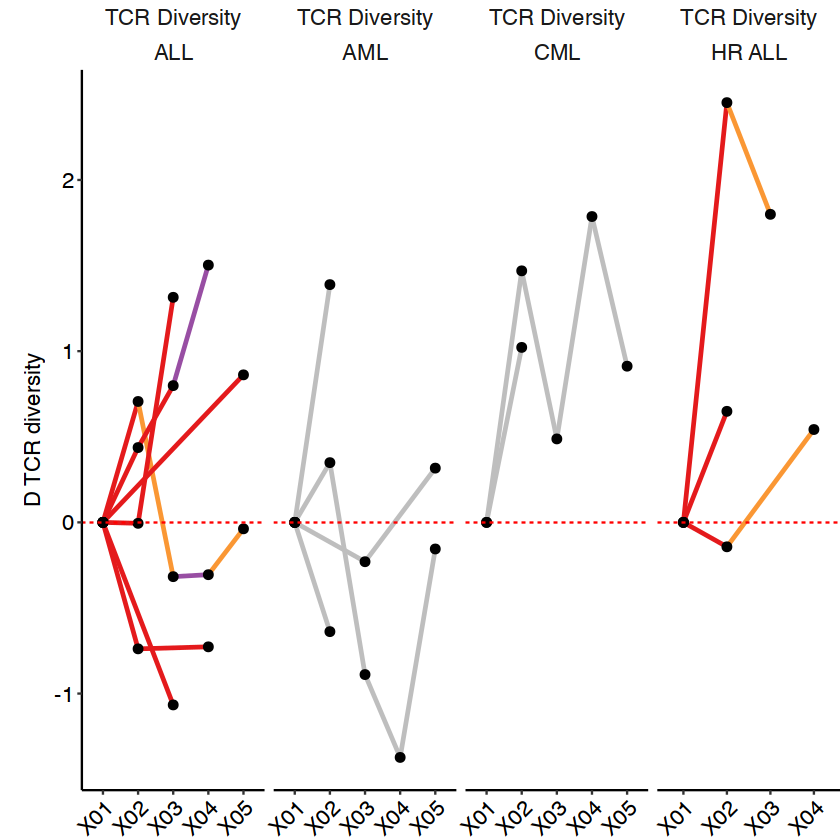

In [36]:
p_shann_leu

In [37]:
# last_timepoint <- diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Leukemia", ] %>%
#     group_by(Patient) %>%
#     filter(cycle == max(cycle))
# last_timepoint$cycleno <- as.numeric(gsub("X0", "", last_timepoint$cycle))

# p_cfshann_leu + geom_text_repel(
#     data = last_timepoint,
#     aes(label = Age),
#     hjust = "left",
#     direction = "y",
#     nudge_x = 6.5 - last_timepoint$cycleno,
#     size = 3,
#     xlim = c(4, NA),
#     segment.color = "black"
# ) + facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top")


In [38]:
# q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Leukemia" &
#     diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))


In [39]:
p_cfshann_leu <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Leukemia", ],
    "cycle", "regimen", colpal
)

p_cfshann_leu <- p_cfshann_leu + theme(legend.position = "none") +
    facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 
    # annotate("ribbon",
    #     x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
    #     alpha = 0.3, fill = "light grey"
    # )


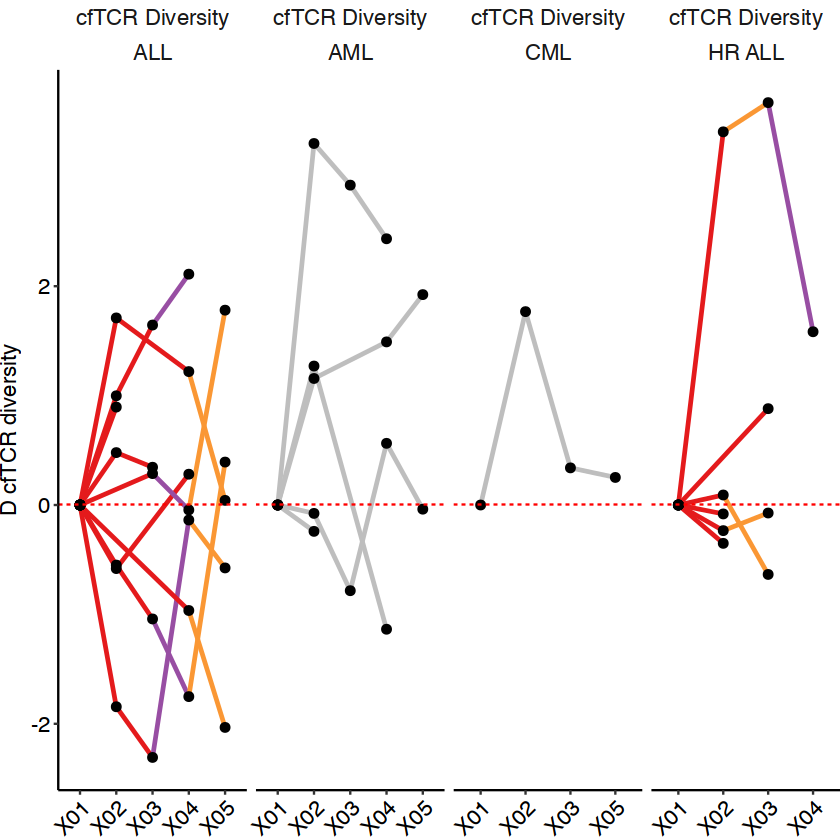

In [40]:
p_cfshann_leu

In [41]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,Naïve%,-0.4373741
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,SCM%,0.4160531
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,CM%,0.9388408
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,EM%,0.1749391
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,TE%,-0.4073194
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,0,Naïve%,-0.4262616


In [42]:
pbmc1_long_cells$marker <- factor(pbmc1_long_cells$marker, levels = c("Naïve%", "SCM%", "CM%", "EM%", "TE%"))

In [43]:
cancergroup <- "Leukemia"

mymat <- data.frame(
    "marker" = rep(unique(pbmc1_long_cells$marker[pbmc1_long_cells$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

for (i in unique(pbmc1_long_cells$marker)) {
    mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.1)
    mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.9)
    mymat$x[mymat$marker == i] <- c(-Inf, Inf)
}


In [44]:
mymat

marker,x,q10,q90
<fct>,<dbl>,<dbl>,<dbl>
Naïve%,-Inf,-1.7949945,1.7019850
SCM%,-Inf,-0.9212834,0.7470105
CM%,-Inf,-0.4905269,2.0151900
EM%,-Inf,-1.4423425,2.9432132
TE%,-Inf,-2.1578850,1.7555736
Naïve%,Inf,-1.7949945,1.7019850
SCM%,Inf,-0.9212834,0.7470105
CM%,Inf,-0.4905269,2.0151900
EM%,Inf,-1.4423425,2.9432132


In [45]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<fct>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,Naïve%,-0.4373741
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,SCM%,0.4160531
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,CM%,0.9388408
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,EM%,0.1749391
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,TE%,-0.4073194
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,0,Naïve%,-0.4262616


In [46]:
tail(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Leukemia", ])

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<fct>,<dbl>
CHP_399_04,CHP_399,X04,Leukemia,HR ALL,2,Vincristine/Cyclophosphamide,0,TE%,0.2641824
CHP_411_01,CHP_411,X01,Leukemia,HR ALL,16,Vincristine,1,Naïve%,0.0000000
CHP_411_01,CHP_411,X01,Leukemia,HR ALL,16,Vincristine,1,SCM%,0.0000000
CHP_411_01,CHP_411,X01,Leukemia,HR ALL,16,Vincristine,1,CM%,0.0000000
CHP_411_01,CHP_411,X01,Leukemia,HR ALL,16,Vincristine,1,EM%,0.0000000
CHP_411_01,CHP_411,X01,Leukemia,HR ALL,16,Vincristine,1,TE%,0.0000000


In [47]:
table(pbmc1_long_cells$Patient[pbmc1_long_cells$marker == "CM%" & pbmc1_long_cells$cancergroup == "Leukemia"])


CHP_347 CHP_349 CHP_352 CHP_353 CHP_357 CHP_367 CHP_373 CHP_377 CHP_378 CHP_383 
      5       2       2       5       5       2       3       2       3       4 
CHP_391 CHP_392 CHP_396 CHP_397 CHP_398 CHP_399 CHP_402 CHP_405 CHP_410 CHP_411 
      3       3       3       5       5       4       3       3       2       3 
CHP_413 CHP_420 CHP_421 CHP_424 CHP_428 
      4       3       3       2       2 

In [48]:
    segments_data <- pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Leukemia", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_leu <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

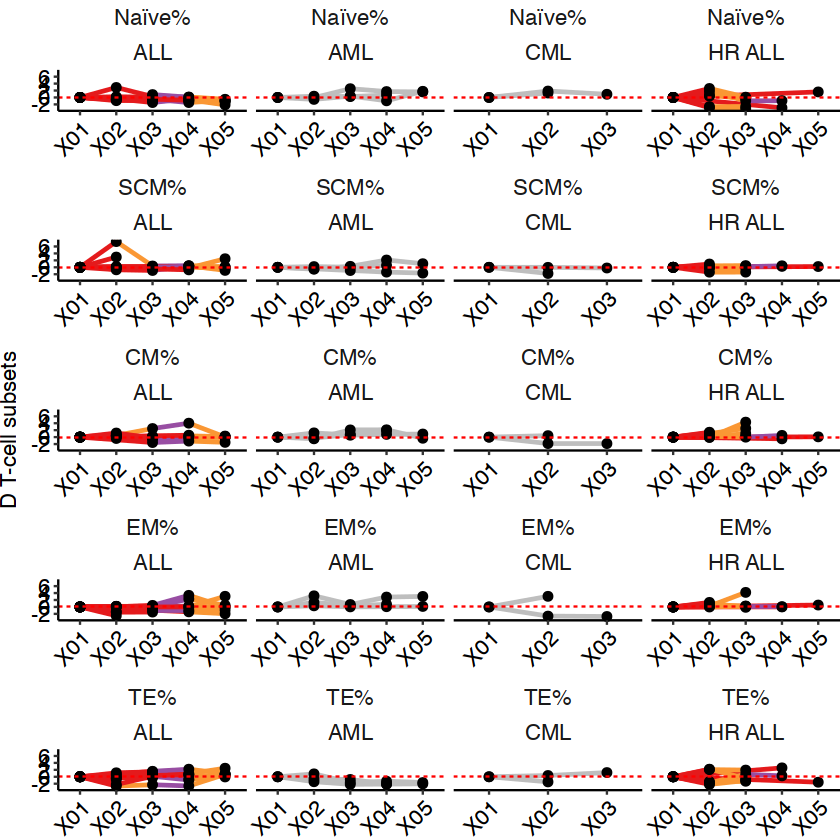

In [49]:
p_leu

In [50]:
# p_leu <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) +
#     geom_point(aes(color = factor(Relapse)), cex = 2) +
#     geom_line(aes(group = Patient, color = factor(Relapse))) +
#      scale_color_manual(values = c("0" = "blue", "1" = "red")) +
#     myplot +
#     myaxis +
#     theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
#         axis.text.x = element_blank(),
#         axis.title.x = element_blank(), legend.position = "none"
#     ) +
# # geom_ribbon(data = mymat, 
# #     aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
# #   ) +
#     facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
#     theme(
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D T-cell subsets") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [51]:
pdf(paste0(plotpath, "p_leu_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_leu)
dev.off()

pdf 
  2

In [52]:
# cancergroup <- "Leukemia"

# mymat <- data.frame(
#     "marker" = rep(unique(pbmc1_long_ic$marker[pbmc1_long_ic$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for (i in unique(pbmc1_long_ic$marker)) {
#     mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.1)
#     mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.9)
#     mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }


In [53]:
    segments_data <- pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Leukemia", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_leu_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [54]:
# p_leu_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) +
#     geom_point(aes(color = factor(Relapse)), cex = 2) +
#     geom_line(aes(group = Patient, color = factor(Relapse))) +
#     scale_color_manual(values = c("0" = "blue", "1" = "red")) +
#     myplot +
#     myaxis +
#     theme(
#         plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
#         axis.text.x = element_blank(),
#         axis.title.x = element_blank(), legend.position = "none"
#     ) +
#     geom_ribbon(
#         data = mymat,
#         aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
#     ) +
#     facet_wrap(~ marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
#     theme(
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D Immune Checkpoint proteins") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) +
#     geom_hline(yintercept = 0, linetype = "dashed", color = "red")


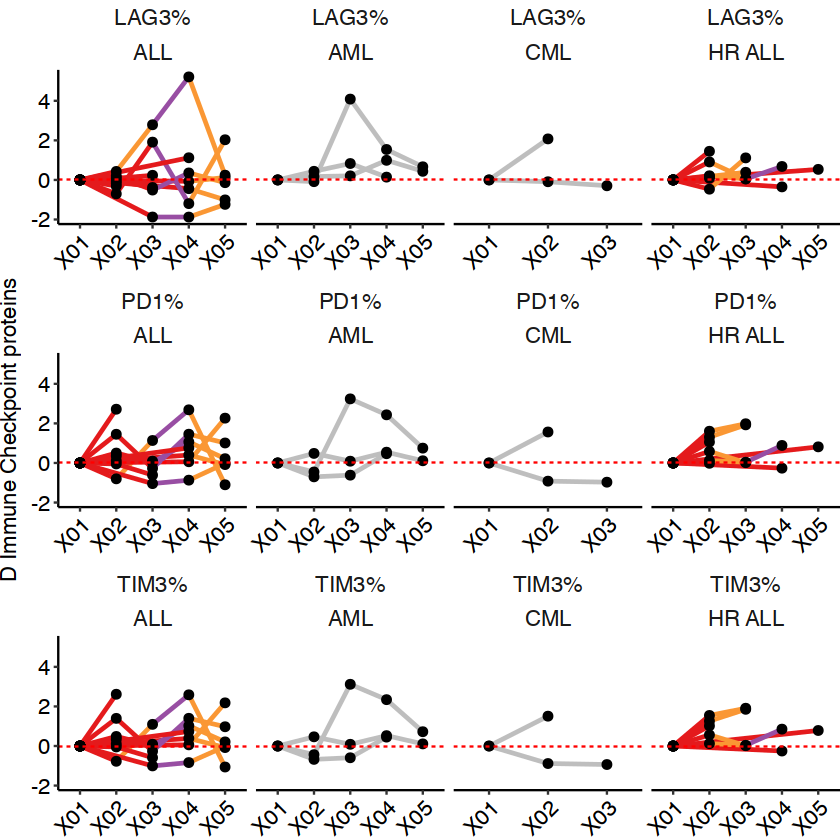

In [55]:
p_leu_ic

In [56]:
pdf(paste0(plotpath, "p_leu_ic_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_leu_ic)
dev.off()


pdf 
  2

#### Lym

In [57]:
# q_10_90 <- quantile(diff_log10shann$Difference[diff_log10shann$cancergroup == "Lymphoma" &
#     diff_log10shann$cycle != "X01"], c(0.1, 0.9))


In [58]:
p_shann_lym <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Lymphoma", ],
    "cycle", "regimen", colpal
)

In [59]:
# p_shann_lym <- delta_basespiderplot.fx(
#     diff_log10shann[diff_log10shann$cancergroup == "Lymphoma", ],
#     "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
# ) + theme(legend.position = "none")

In [60]:
p_shann_lym <- p_shann_lym + theme(legend.position = "none") +
  facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  # scale_x_discrete(get_breaks("cycle"),
  #   labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  # ) + 
  geom_hline(yintercept = 0, linetype = "dashed", color = "red")

In [61]:
# p_shann_lym <- p_shann_lym + theme(legend.position = "none") +
#   facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
#   theme(
#     plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
#     axis.title.x = element_blank(),
#     legend.position = "none",
#     strip.text.x = element_text(size = 13),
#     strip.background.x = element_blank(),
#     strip.placement = "outside"
#   ) +
#   ylab("D TCR diversity") +
#   scale_x_discrete(get_breaks("cycle"),
#     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5") ) +
#       annotate("ribbon",
#     x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
#     alpha = 0.3, fill = "light grey"
#   ) +
#   geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

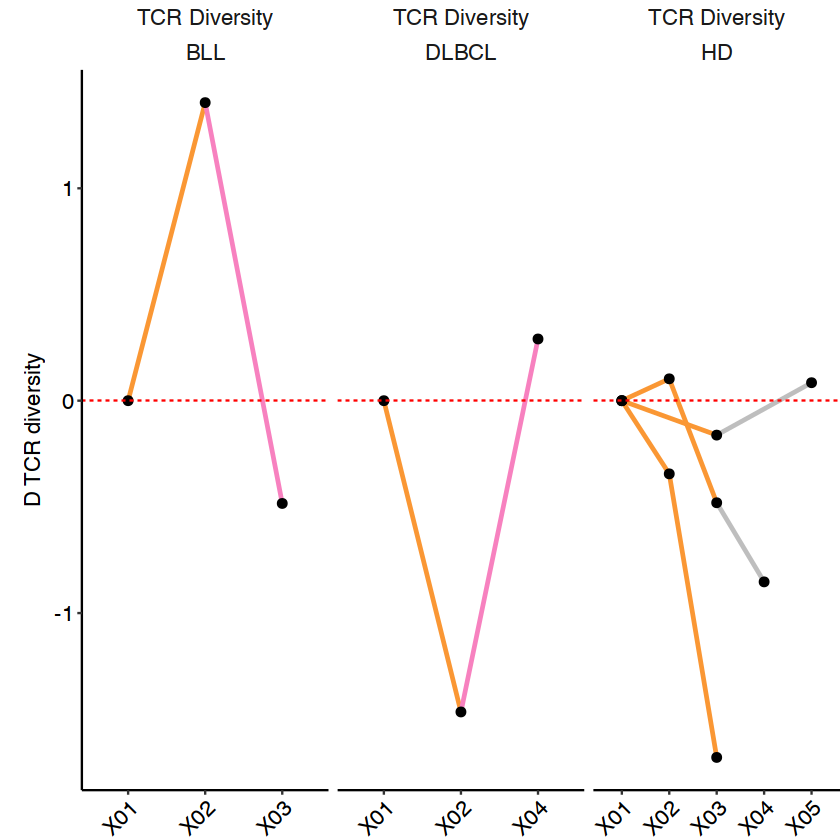

In [62]:
p_shann_lym

In [63]:
# q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Lymphoma" &
#     diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))


In [64]:
# p_cfshann_lym <- delta_basespiderplot.fx(
#     diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Lymphoma", ],
#     "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
# )

In [65]:
diff_log10shann_cfdna[ diff_log10shann_cfdna$Disease_type == "BL", ]

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,log10shann_scaled,Difference,grp
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,"<dbl[,1]>","<dbl[,1]>",<chr>
CHP_344_01,CHP_344,X01,0.0,247.80,6,BL,0.0,NA,NA,...,batch5_cfDNA_25Jun2020/mixcr/clones/CLONES_TRBCHP_344-01_cfDNA.txt,cfDNA,CHP,0.8187141,CHP_344_01_cfDNA,capTCR-seq,Vincristine/Cyclophosphamide,0.37214570,0.0000000,cfTCR Diversity
CHP_344_02,CHP_344,X02,0.0,829.08,6,BL,0.0,NA,NA,...,batch3a9_cfDNA_10Jul2020/mixcr/clones/CLONES_TRBCHP_344-02_cfDNA.txt,cfDNA,CHP,0.2164106,CHP_344_02_cfDNA,capTCR-seq,Vincristine/Methotrexate/Cyclophosphamide,-1.00120852,-1.3733542,cfTCR Diversity
CHP_344_03,CHP_344,X03,0.0,80.04,6,BL,0.0,NA,NA,...,remaining_batch_2_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_344-03-cfDNA.txt,cfDNA,CHP,0.1477113,CHP_344_03_cfDNA,capTCR-seq,Methotrexate,-1.15785453,-1.5300002,cfTCR Diversity
CHP_344_04,CHP_344,X04,0.0,0.00,6,BL,0.0,NA,NA,...,batch3a9_cfDNA_10Jul2020/mixcr/clones/CLONES_TRBCHP_344-04_cfDNA.txt,cfDNA,CHP,0.7283065,CHP_344_04_cfDNA,capTCR-seq,Methotrexate,0.16600106,-0.2061446,cfTCR Diversity
CHP_344_05,CHP_344,X05,0.0,134.32,6,BL,0.0,NA,NA,...,batch3a9_cfDNA_10Jul2020/mixcr/clones/CLONES_TRBCHP_344-05_cfDNA.txt,cfDNA,CHP,0.2956427,CHP_344_05_cfDNA,capTCR-seq,Others,-0.82054575,-1.1926915,cfTCR Diversity
CHP_371_01,CHP_371,X01,2.1,333.20,15,BL,2.1,1014,37,...,batch1_cfDNA_30Jan2020/mixcr/clones/CLONES_TRBCHP_371-01-cfDNA.txt,cfDNA,CHP,0.5354682,CHP_371_01_cfDNA,capTCR-seq,Vincristine/Cyclophosphamide,-0.27370301,0.0000000,cfTCR Diversity
CHP_371_03,CHP_371,X03,0.0,0.00,15,BL,0.0,NA,NA,...,batch1_cfDNA_30Jan2020/mixcr/clones/CLONES_TRBCHP_371-03-cfDNA.txt,cfDNA,CHP,0.2077319,CHP_371_03_cfDNA,capTCR-seq,Methotrexate,-1.02099744,-0.7472944,cfTCR Diversity
CHP_371_04,CHP_371,X04,0.0,289.68,15,BL,0.0,NA,NA,...,batch3a9_cfDNA_10Jul2020/mixcr/clones/CLONES_TRBCHP_371-04_cfDNA.txt,cfDNA,CHP,0.3364604,CHP_371_04_cfDNA,capTCR-seq,Methotrexate,-0.72747455,-0.4537715,cfTCR Diversity
CHP_371_05,CHP_371,X05,0.0,128.80,15,BL,0.0,NA,NA,...,cfDNA_Matched_Priority_Pool1_19Nov2021/mixcr/clones/CLONES_TRBCHP_371-05_cfDNA.txt,cfDNA,CHP,0.3180337,CHP_371_05_cfDNA,capTCR-seq,Others,-0.76949052,-0.4957875,cfTCR Diversity


In [66]:
p_cfshann_lym <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Lymphoma", ],
    "cycle", "regimen", colpal
)

p_cfshann_lym <- p_cfshann_lym + theme(legend.position = "none") +
    facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 


In [67]:
# p_cfshann_lym <- p_cfshann_lym + theme(legend.position = "none") +
#     facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
#     theme(
#         plot.margin = unit(c(0, 0, 0, 0), "cm"),
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D cfTCR diversity") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5") ) +
#           annotate("ribbon",
#     x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
#     alpha = 0.3, fill = "light grey"
#   ) +
#     geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

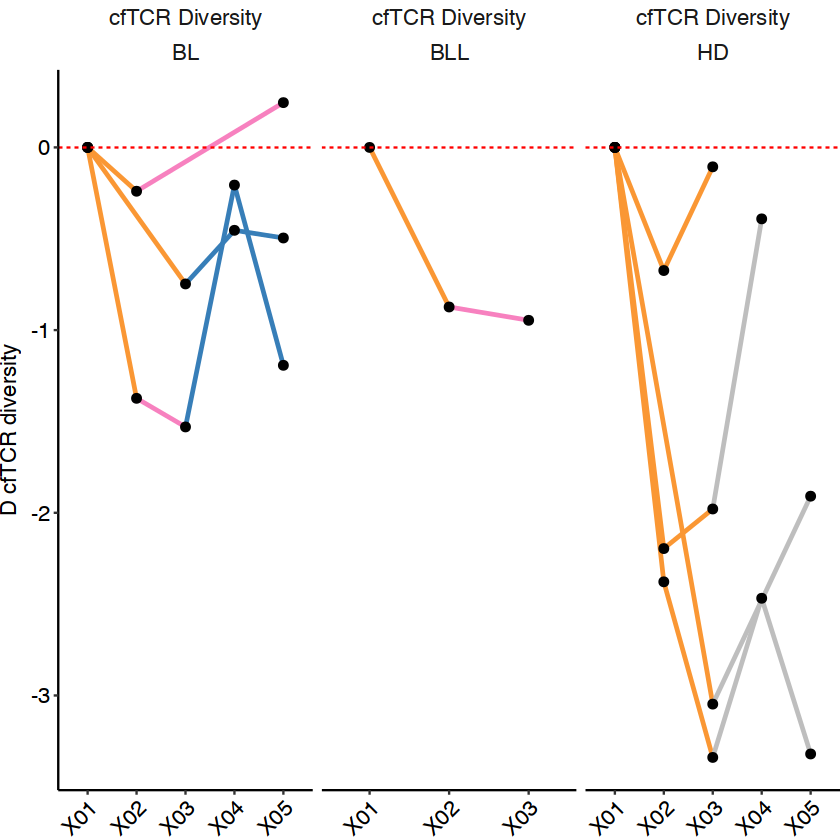

In [68]:
p_cfshann_lym

In [69]:
pdf(paste0(plotpath, "p_lym_cftcr_spiderplots_disease_type.pdf"), width = 10, height = 4)
cowplot::plot_grid(p_cfshann_lym)
dev.off()

pdf 
  2

In [70]:
# cancergroup <- "Lymphoma"

# mymat <- data.frame(
#     "marker" = rep(unique(pbmc1_long_cells$marker[pbmc1_long_cells$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for (i in unique(pbmc1_long_cells$marker)) {
#     mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
#         pbmc1_long_cells$cycle != "X01" &
#         pbmc1_long_cells$marker == i], 0.1)
#     mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
#         pbmc1_long_cells$cycle != "X01" &
#         pbmc1_long_cells$marker == i], 0.9)
#     mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }


In [71]:
pbmc1_long_cells[ pbmc1_long_cells$Disease_type == "BL", ]

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<fct>,<dbl>
CHP_386_01,CHP_386,X01,Lymphoma,BL,13,Vincristine/Cyclophosphamide,0,Naïve%,0.00000000
CHP_386_01,CHP_386,X01,Lymphoma,BL,13,Vincristine/Cyclophosphamide,0,SCM%,0.00000000
CHP_386_01,CHP_386,X01,Lymphoma,BL,13,Vincristine/Cyclophosphamide,0,CM%,0.00000000
CHP_386_01,CHP_386,X01,Lymphoma,BL,13,Vincristine/Cyclophosphamide,0,EM%,0.00000000
CHP_386_01,CHP_386,X01,Lymphoma,BL,13,Vincristine/Cyclophosphamide,0,TE%,0.00000000
CHP_386_03,CHP_386,X03,Lymphoma,BL,13,Methotrexate,0,Naïve%,-0.91939599
CHP_386_03,CHP_386,X03,Lymphoma,BL,13,Methotrexate,0,SCM%,0.36833792
CHP_386_03,CHP_386,X03,Lymphoma,BL,13,Methotrexate,0,CM%,-2.48528403
CHP_386_03,CHP_386,X03,Lymphoma,BL,13,Methotrexate,0,EM%,0.04860965


In [72]:
(segments_data[ segments_data$Disease_type == "BL", ])

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,Relapse,marker,Diff,x_start,y_start,x_end,y_end,segment_regimen
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<fct>


In [73]:
    segments_data <- pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Lymphoma", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_lym <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
     ylab("D T-cell subsets") #+
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

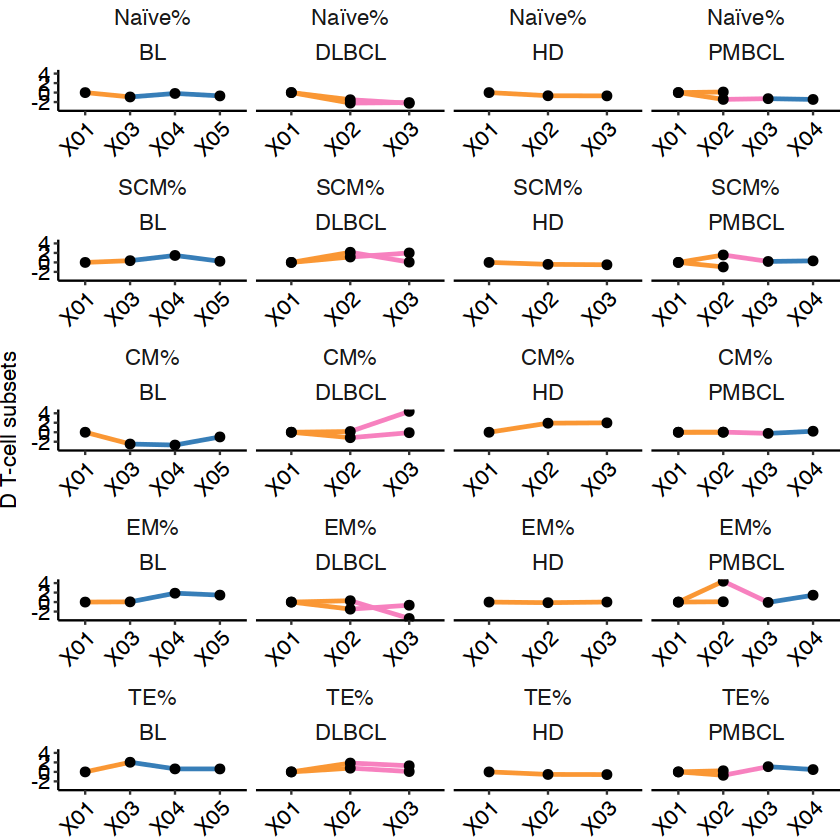

In [74]:
p_lym

In [75]:
# p_lym <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) +
#     geom_point(aes(color = factor(Relapse)), cex = 2) +
#     geom_line(aes(group = Patient, color = factor(Relapse))) +
#     scale_color_manual(values = c("0" = "blue", "1" = "red")) +
#     myplot +
#     myaxis +
#     theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
#         axis.text.x = element_blank(),
#         axis.title.x = element_blank(), legend.position = "none"
#     ) +
#         geom_ribbon(
#         data = mymat,
#         aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
#     ) +
#     facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
#     theme(
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D T-cell subsets") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [76]:
pdf(paste0(plotpath, "p_lym_cells_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_lym)
dev.off()

pdf 
  2

In [77]:
# cancergroup <- "Lymphoma"

# mymat <- data.frame(
#     "marker" = rep(unique(pbmc1_long_ic$marker[pbmc1_long_ic$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for (i in unique(pbmc1_long_ic$marker)) {
#     mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.1)
#     mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.9)
#     mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }


In [78]:
    segments_data <- pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Lymphoma", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_lym_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [79]:
# p_lym_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) +
#     geom_point(aes(color = factor(Relapse)), cex = 2) +
#     geom_line(aes(group = Patient, color = factor(Relapse))) +
#     scale_color_manual(values = c("0" = "blue", "1" = "red"))  +
#     myplot +
#     myaxis +
#     theme(plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
#         axis.text.x = element_blank(),
#         axis.title.x = element_blank(), legend.position = "none"
#     ) +
#         geom_ribbon(
#         data = mymat,
#         aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
#     ) +
#     facet_wrap(~marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
#     theme(
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D Immune Checkpoint proteins") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

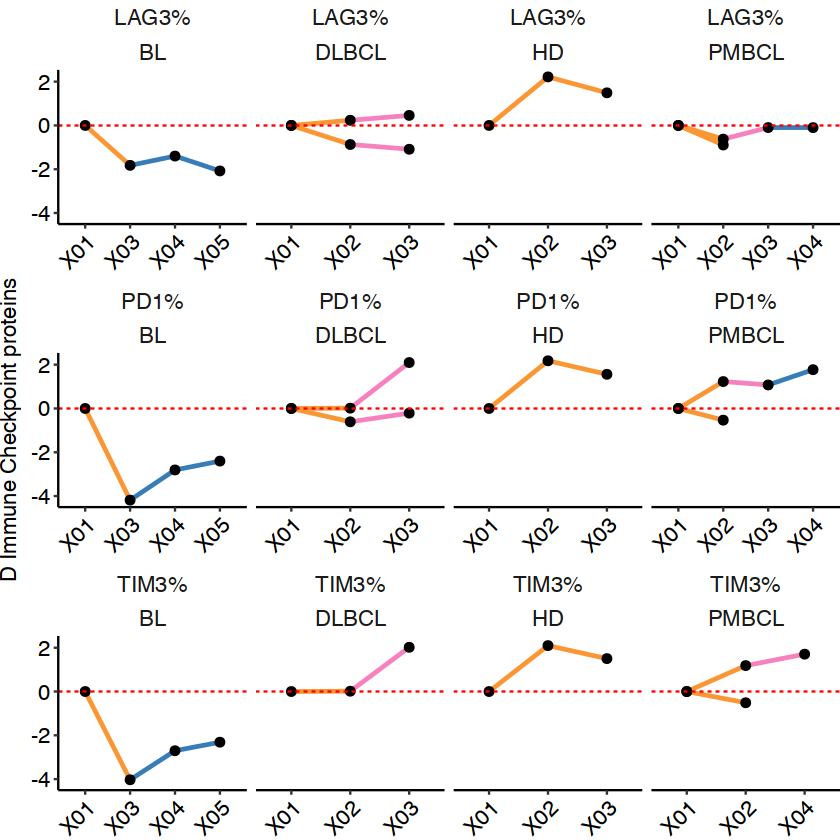

In [80]:
p_lym_ic

In [81]:
pdf(paste0(plotpath, "p_lym_ic_spiderplots_disease_type.pdf"), width = 10, height = 6)
cowplot::plot_grid(p_lym_ic)
dev.off()

pdf 
  2

#### Solid

In [82]:
p_shann_solid <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Solid tumors", ],
    "cycle", "regimen", colpal
)

In [83]:
p_shann_solid <- p_shann_solid + theme(legend.position = "none") +
  facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  # scale_x_discrete(get_breaks("cycle"),
  #   labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  # ) + 
  geom_hline(yintercept = 0, linetype = "dashed", color = "red")

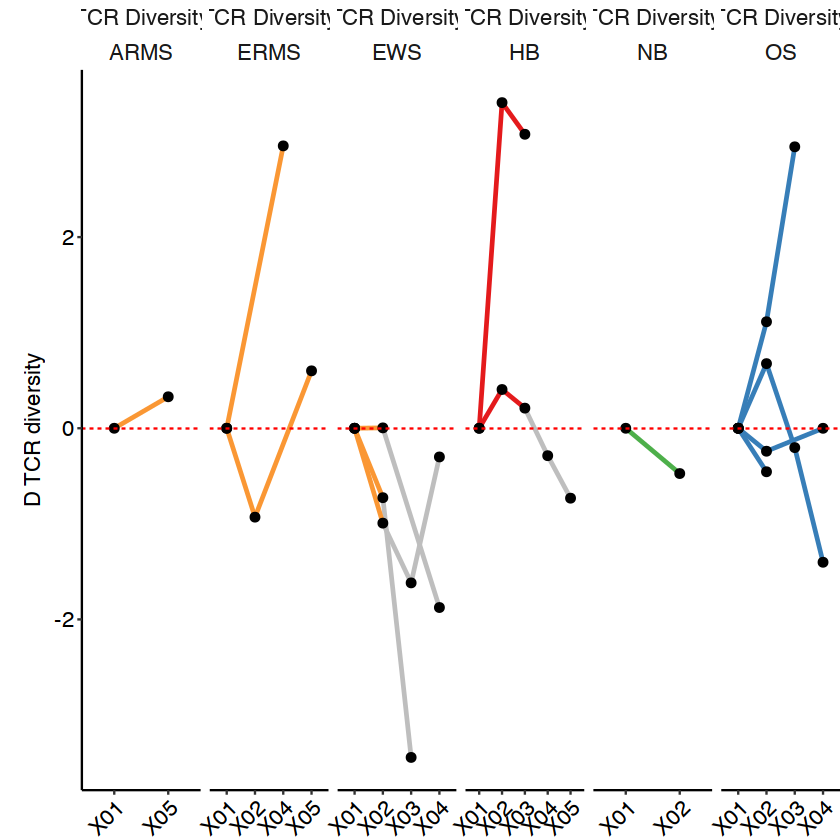

In [84]:
p_shann_solid

In [85]:
# q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Solid tumors" &
#     diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))


In [86]:
p_cfshann_solid <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Solid tumors", ],
    "cycle", "regimen", colpal
)

p_cfshann_solid <- p_cfshann_solid + theme(legend.position = "none") +
    facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 


In [87]:
# p_cfshann_solid <- p_cfshann_solid + theme(legend.position = "none") +
#     facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
#     theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D cfTCR diversity") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) + 
#       annotate("ribbon",
#     x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
#     alpha = 0.3, fill = "light grey"
#   ) +
#   geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

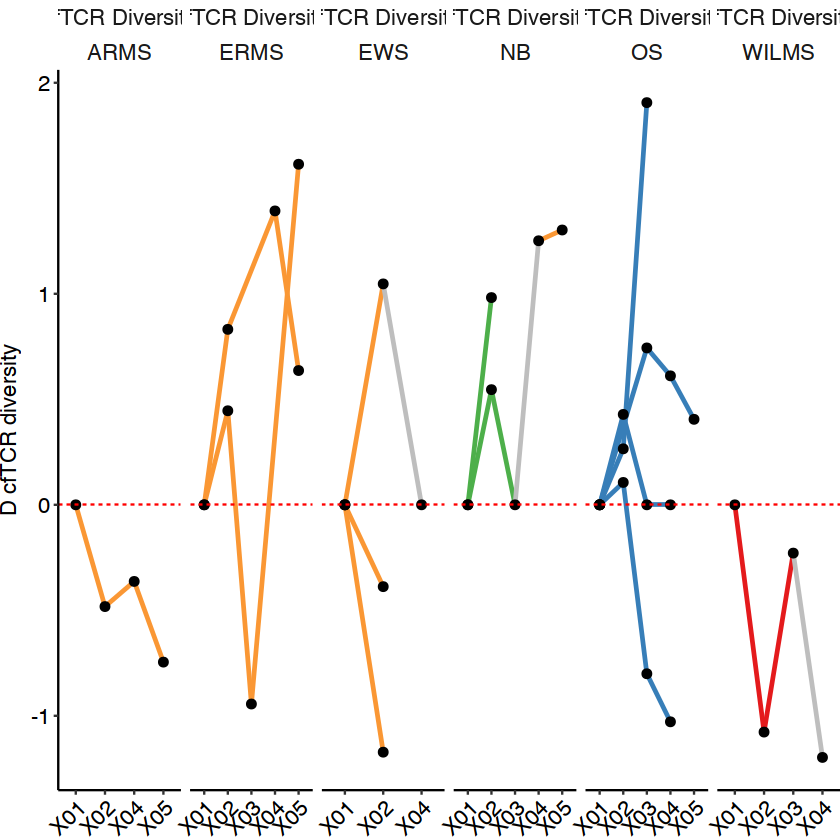

In [88]:
p_cfshann_solid

In [89]:
# cancergroup <- "Solid tumors"

# mymat <- data.frame(
#     "marker" = rep(unique(pbmc1_long_cells$marker[pbmc1_long_cells$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for (i in unique(pbmc1_long_cells$marker)) {
#     mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
#         pbmc1_long_cells$cycle != "X01" &
#         pbmc1_long_cells$marker == i], 0.1)
#     mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
#         pbmc1_long_cells$cycle != "X01" &
#         pbmc1_long_cells$marker == i], 0.9)
#     mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }


In [90]:
    segments_data <- pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Solid tumors", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_solid <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Solid tumors", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

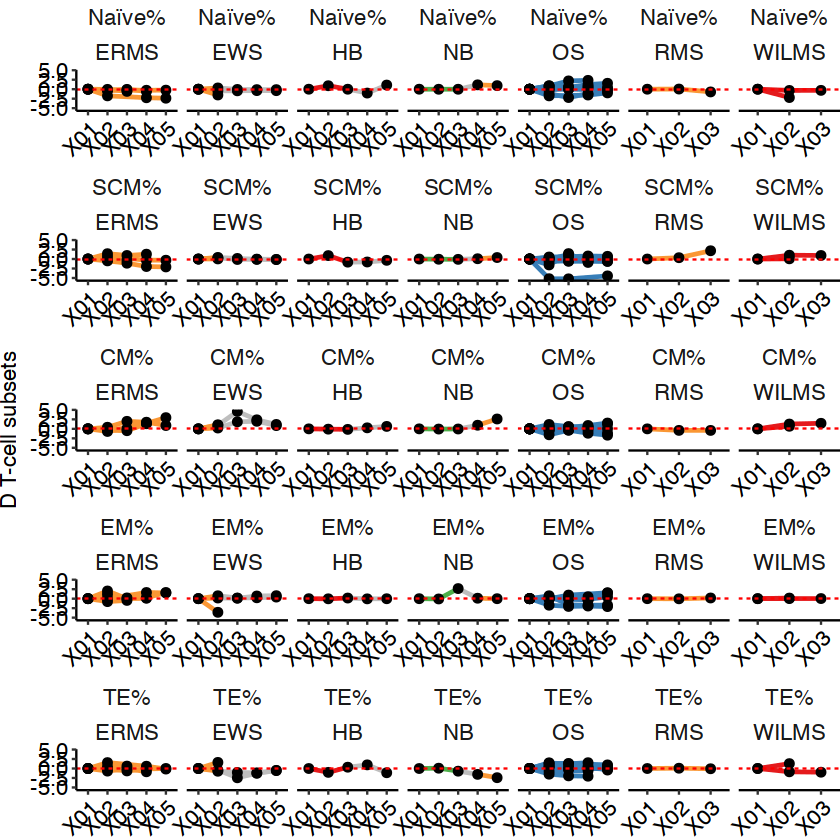

In [91]:
p_solid

In [92]:
pdf(paste0(plotpath, "p_solid_cells_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_solid)
dev.off()

pdf 
  2

In [93]:
# cancergroup <- "Solid tumors"

# mymat <- data.frame(
#     "marker" = rep(unique(pbmc1_long_ic$marker[pbmc1_long_ic$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for (i in unique(pbmc1_long_ic$marker)) {
#     mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.1)
#     mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.9)
#     mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }


In [94]:
    segments_data <- pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Solid tumors", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_solid_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Solid tumors", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [95]:
pdf(paste0(plotpath, "p_solid_ic_spiderplots_disease_type.pdf"), width = 10, height = 8)
cowplot::plot_grid(p_solid_ic)
dev.off()


pdf 
  2

## Specific observations

Leu

In [96]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<fct>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,Naïve%,-0.4373741
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,SCM%,0.4160531
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,CM%,0.9388408
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,EM%,0.1749391
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,TE%,-0.4073194
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,0,Naïve%,-0.4262616


In [97]:
pbmc1_long_cells$marker <- as.character(pbmc1_long_cells$marker)

In [98]:
tmp1 <- pbmc1_long_cells[pbmc1_long_cells$Disease_type %in% c("ALL", "HR ALL") &
    pbmc1_long_cells$marker %in% c("Naïve%", "CM%"), ]

In [99]:
tmp1$marker <- factor(tmp1$marker, levels = c("Naïve%", "CM%"))

In [100]:
# cancergroup <- "Leukemia"

# mymat <- data.frame(
#     "marker" = rep(unique(tmp1$marker[tmp1$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for (i in unique(tmp1$marker)) {
#     mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
#         pbmc1_long_cells$cycle != "X01" &
#         pbmc1_long_cells$marker == i], 0.1)
#     mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
#         pbmc1_long_cells$cycle != "X01" &
#         pbmc1_long_cells$marker == i], 0.9)
#     mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }

In [101]:
    segments_data <- tmp1 %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_all_hrall_naive_cm <- ggplot(tmp1, aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    ggh4x::facet_wrap2(~ marker + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line(colour = "black")
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

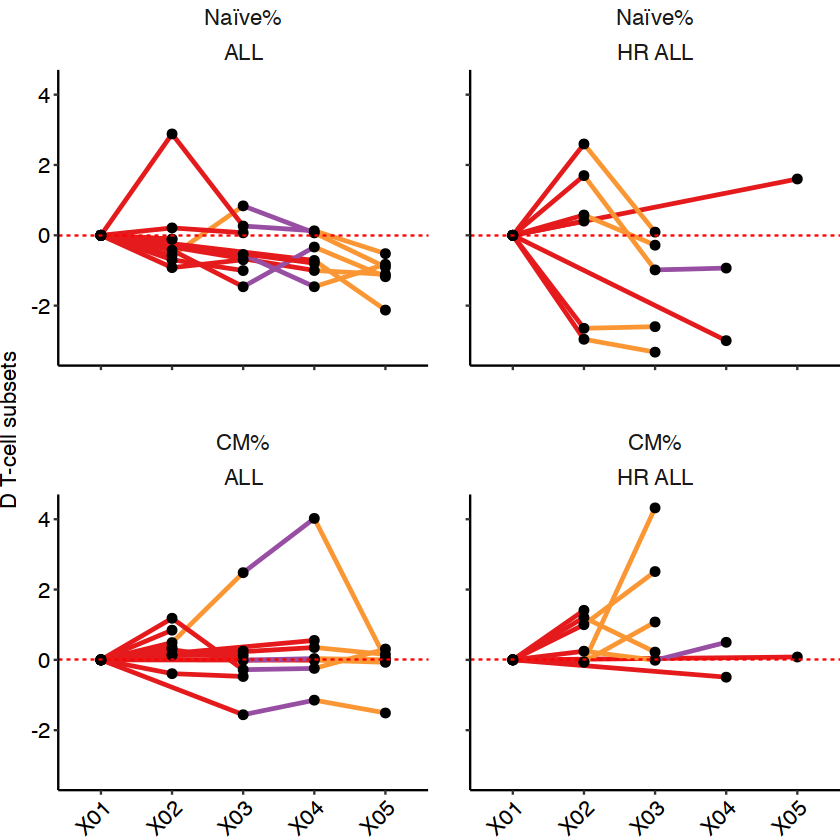

In [102]:
p_all_hrall_naive_cm

In [103]:
pdf(paste0(plotpath, "p_ALL_HRALL_Naive_CM.pdf"), width = 4, height = 6)
cowplot::plot_grid(p_all_hrall_naive_cm, labels = "A")
dev.off()

pdf 
  2

In [104]:
tmp2 <- diff_log10shann_cfdna[diff_log10shann_cfdna$Disease_type %in% c("ALL", "HR ALL", "AML"), ]

In [105]:
tmp2[ tmp2$Difference < -1,]

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,log10shann_scaled,Difference,grp
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,"<dbl[,1]>","<dbl[,1]>",<chr>
CHP_360_02,CHP_360,X02,0.0,75.24,6,ALL,0.0,NA,NA,...,batch1_cfDNA_30Jan2020/mixcr/clones/CLONES_TRBCHP_360-02-cfDNA.txt,cfDNA,CHP,0.5119517,CHP_360_02_cfDNA,capTCR-seq,Vincristine,-0.3273247,-1.844062,cfTCR Diversity
CHP_360_03,CHP_360,X03,0.0,0.00,6,ALL,0.0,NA,NA,...,remaining_batch_2_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_360-03_cfDNA.txt,cfDNA,CHP,0.3087965,CHP_360_03_cfDNA,capTCR-seq,Vincristine/Methotrexate,-0.7905529,-2.307290,cfTCR Diversity
CHP_376_04,CHP_376,X04,0.0,0.00,1,AML,0.0,NA,NA,...,remaining_batch_2_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_376-04_cfDNA.txt,cfDNA,CHP,0.0000000,CHP_376_04_cfDNA,capTCR-seq,Others,-1.4946613,-1.135488,cfTCR Diversity
CHP_378_05,CHP_378,X05,1.1,0.00,1,ALL,1.1,2573,34,...,remaining_batch_4_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_378-05_cfDNA.txt,cfDNA,CHP,0.3911106,CHP_378_05_cfDNA,capTCR-seq,Vincristine/Methotrexate,-0.6028629,-2.033015,cfTCR Diversity
CHP_388_03,CHP_388,X03,18.0,254.98,4,ALL,18.0,2457,4,...,cfDNA_Matched_Priority_Pool1_19Nov2021/mixcr/clones/CLONES_TRBCHP_388-03_cfDNA.txt,cfDNA,CHP,0.5751342,CHP_388_03_cfDNA,capTCR-seq,Vincristine/Methotrexate,-0.1832578,-1.041600,cfTCR Diversity
CHP_388_04,CHP_388,X04,26.5,0.00,4,ALL,26.5,1303,0,...,batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_388-04_cfDNA.txt,cfDNA,CHP,0.2638804,CHP_388_04_cfDNA,capTCR-seq,Vincristine/Cyclophosphamide,-0.8929692,-1.751312,cfTCR Diversity


In [106]:
p_cfshann_leu <- delta_basespiderplot.fx(
    tmp2,
    "cycle", "regimen", colpal
)

In [107]:
# p_cfshann_leu <- delta_basespiderplot.fx(
#     tmp2,"cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
# )

In [108]:
# q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Leukemia" &
#     diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))

In [109]:
p_cfshann_leu <- p_cfshann_leu + theme(legend.position = "none") +
    ggh4x::facet_wrap2(~ grp + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 



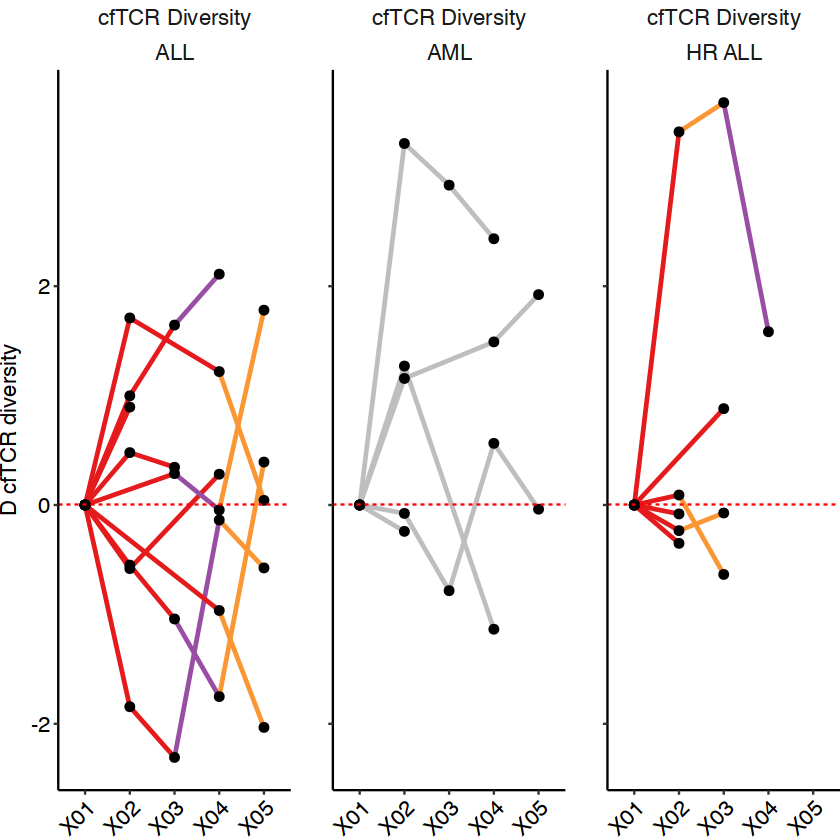

In [110]:
p_cfshann_leu

In [111]:
pdf(paste0(plotpath, "p_ALL_HRALL_AML_cfTCR.pdf"), width = 6, height = 3)
cowplot::plot_grid(p_cfshann_leu, labels = "B")
dev.off()

pdf 
  2

Lym

In [112]:
tmp3 <- diff_log10shann_cfdna[diff_log10shann_cfdna$Disease_type %in% c("BL", "HD"), ]

In [113]:
p_cfshann_lym <- delta_basespiderplot.fx(
    tmp3,
    "cycle", "regimen", colpal
)

In [114]:
p_cfshann_lym <- p_cfshann_lym + theme(legend.position = "none") +
    ggh4x::facet_wrap2(~ grp + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
 geom_hline(yintercept = 0, linetype = "dashed", color = "red") 



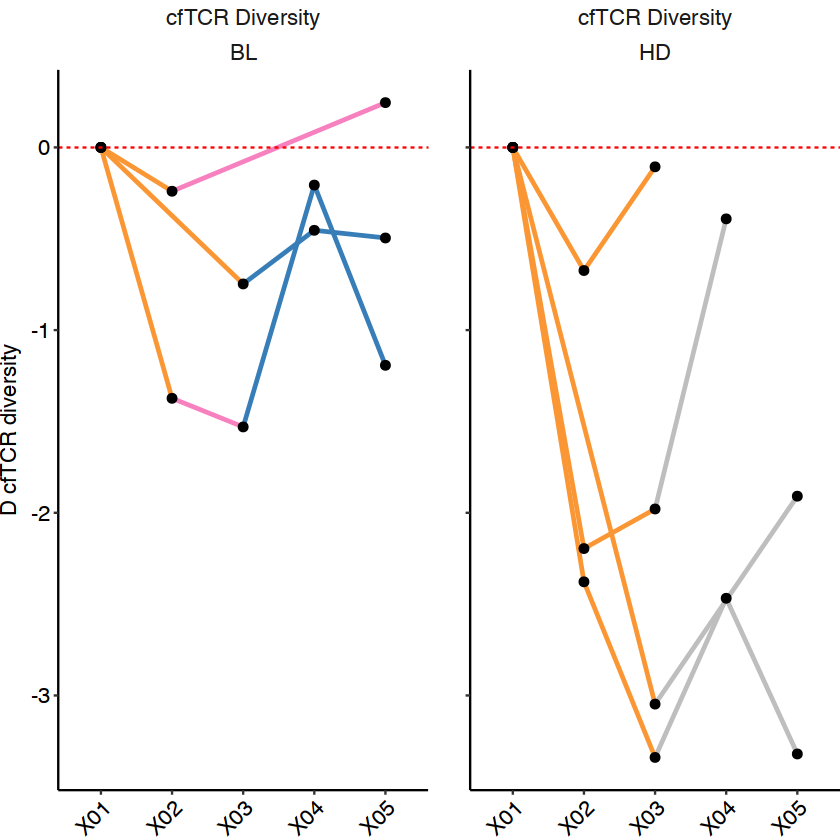

In [115]:
p_cfshann_lym

In [116]:
pdf(paste0(plotpath, "p_BL_HD_cfTCR.pdf"), width = 4, height = 3)
cowplot::plot_grid(p_cfshann_lym, labels = "C")
dev.off()

pdf 
  2

Solid

In [117]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,Naïve%,-0.4373741
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,SCM%,0.4160531
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,CM%,0.9388408
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,EM%,0.1749391
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,TE%,-0.4073194
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,0,Naïve%,-0.4262616


In [118]:
pbmc1_long_cells$marker <- as.character(pbmc1_long_cells$marker)

In [119]:
tmp4 <- pbmc1_long_cells[pbmc1_long_cells$Disease_type %in% c("ERMS", "EWS", "HB", "NB", "RMS") &
    pbmc1_long_cells$marker == "CM%", ]

In [120]:
    segments_data <- tmp4 %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_solid <- ggplot(tmp4, aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    ggh4x::facet_wrap2(~ marker + Disease_type, axes = "all", remove_labels = "all", nrow = 1) +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line(colour = "black")
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

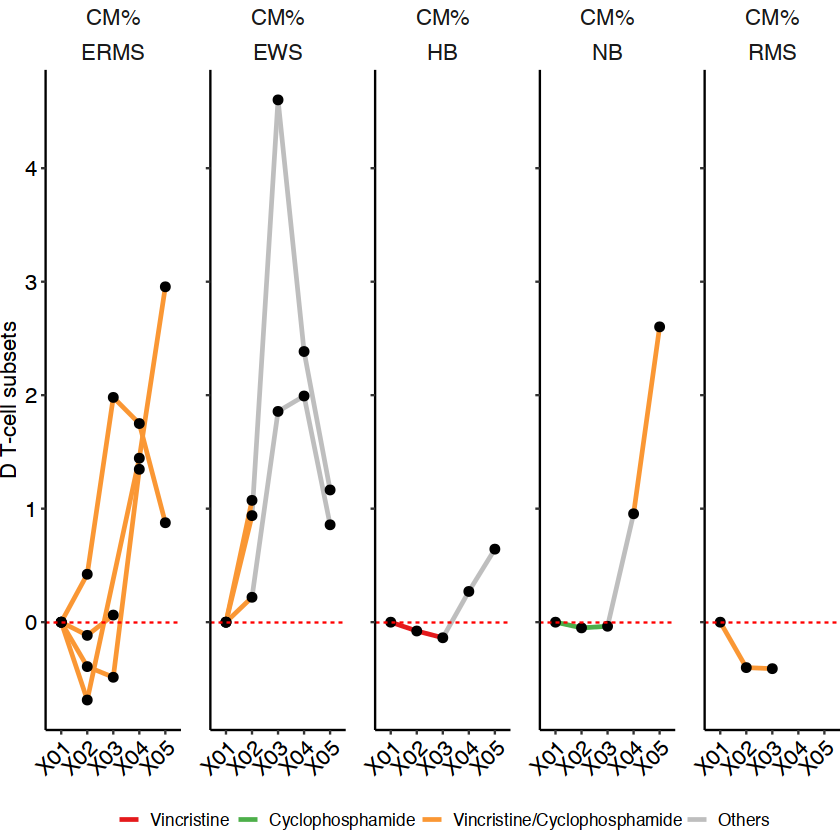

In [123]:
p_solid + theme(legend.position = "bottom")

In [120]:
# p_solid <- ggplot(tmp4, aes(x = cycle, y = Diff)) +
#     geom_point(aes(color = factor(Relapse)), cex = 2) +
#     geom_line(aes(group = Patient, color = factor(Relapse))) +
#     scale_color_manual(values = c("0" = "blue", "1" = "red")) +
#     myplot +
#     myaxis +
#     theme(
#         plot.margin = unit(c(0, 0, 0, 0), "cm"),
#         axis.text.x = element_text(angle = 45, hjust = 1),
#         axis.title.x = element_blank(), legend.position = "none"
#     ) +
#     geom_ribbon(
#         data = mymat,
#         aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
#     ) +
#     ggh4x::facet_wrap2(~ marker + Disease_type,nrow = 1, axes = "all", remove_labels = "all") +
#     theme(
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside",
#         axis.line = element_line(colour = "black")
#     ) +
#     ylab("D T-cell subsets") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) +
#     geom_hline(yintercept = 0, linetype = "dashed", color = "red")


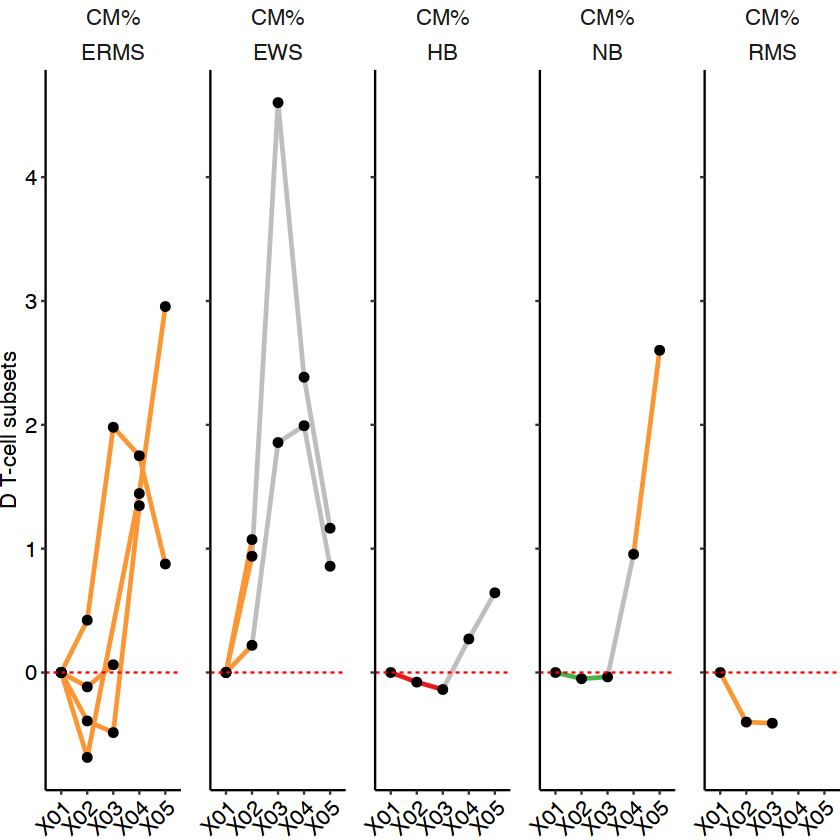

In [121]:
p_solid

In [122]:
pdf(paste0(plotpath, "p_HB_NB_EWS_ERMS_WIL_RMS_CM.pdf"), width = 12, height = 3)
cowplot::plot_grid(p_solid, labels = "D")
dev.off()

pdf 
  2

In [123]:
head(pbmc1_long_ic)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,PD1%,0.2727900
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,LAG3%,2.4464828
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,0,TIM3%,0.2627066
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,0,PD1%,1.8000307
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,0,LAG3%,0.2051438
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,0,TIM3%,1.7334941


In [124]:
tmp6 <- pbmc1_long_ic[pbmc1_long_ic$Disease_type %in% c("ERMS", "OS", "HB") &
    pbmc1_long_ic$marker %in% c("PD1%", "LAG3%"), ]

In [125]:
# cancergroup <- "Solid tumors"

# mymat <- data.frame(
#     "marker" = rep(unique(tmp6$marker[tmp6$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for(i in unique(tmp6$marker)){
# mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#     pbmc1_long_ic$cycle != "X01" &
#     pbmc1_long_ic$marker == i], 0.1)
# mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#     pbmc1_long_ic$cycle != "X01" &
#     pbmc1_long_ic$marker == i], 0.9)
# mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }


In [126]:
    segments_data <- tmp6 %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_s_ic <- ggplot(tmp6, aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    ggh4x::facet_wrap2(~ marker + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line(colour = "black")
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

In [127]:
# p_s_ic <- ggplot(tmp6, aes(x = cycle, y = Diff)) +
#     geom_point(aes(color = factor(Relapse)), cex = 2) +
#     geom_line(aes(group = Patient, color = factor(Relapse))) +
#     scale_color_manual(values = c("0" = "blue", "1" = "red")) +
#     myplot +
#     myaxis +
#     theme(
#         plot.margin = unit(c(0, 0, 0, 0), "cm"),
#         axis.text.x = element_text(angle = 45, hjust = 1),
#         axis.title.x = element_blank(), legend.position = "none"
#     ) +
#     ggh4x::facet_wrap2(~ marker + Disease_type, nrow = 2, axes = "all", remove_labels = "all") +
#     geom_ribbon(
#         data = mymat,
#         aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
#     ) +
#     theme(
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside",
#         axis.line = element_line(colour = "black")
#     ) +
#     ylab("D T-cell subsets") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) +
#     geom_hline(yintercept = 0, linetype = "dashed", color = "red")


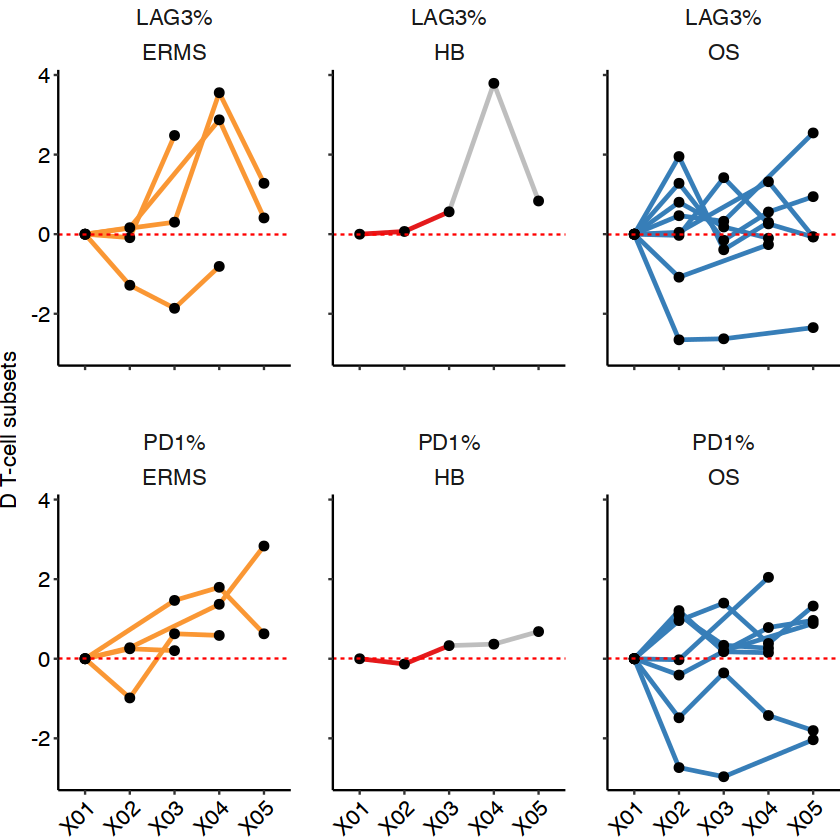

In [128]:
p_s_ic

In [129]:
pdf(paste0(plotpath, "p_HB_ERMS_OS_PD1_LAG3.pdf"), width = 6, height = 6)
cowplot::plot_grid(p_s_ic, labels = "E")
dev.off()

pdf 
  2